<a href="https://colab.research.google.com/github/Abhishek500/ERA/blob/main/S8/ERA_S8_LN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.insert(0,'/content/drive/My Drive/ERA V1')
from model import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
train_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822 ,0.4465), (0.2470, 0.2435, 0.2616))])
test_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822 ,0.4465), (0.2470, 0.2435, 0.2616))])



In [6]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

In [7]:

train = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)

# Load the CIFAR-10 test dataset
test = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)


Files already downloaded and verified
Files already downloaded and verified


In [8]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=32, num_workers=3, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = S8_Model_LN().to(device)
summary(model, input_size=(3, 32, 32))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
         GroupNorm-2           [-1, 32, 32, 32]              64
         Dropout2d-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,432
         GroupNorm-5           [-1, 64, 32, 32]             128
         Dropout2d-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 10, 32, 32]             640
         GroupNorm-8           [-1, 10, 32, 32]              20
         Dropout2d-9           [-1, 10, 32, 32]               0
        MaxPool2d-10           [-1, 10, 16, 16]               0
           Conv2d-11           [-1, 16, 14, 14]           1,440
        GroupNorm-12           [-1, 16, 14, 14]              32

In [9]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))
    #return test_loss

In [10]:
model =  S8_Model_LN().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=1.9844777584075928 Batch_id=1562 Accuracy=35.55: 100%|██████████| 1563/1563 [00:35<00:00, 44.65it/s]



Test set: Average loss: 1.5092, Accuracy: 4513/10000 (45.13%)

EPOCH: 1


Loss=1.1595604419708252 Batch_id=1562 Accuracy=49.51: 100%|██████████| 1563/1563 [00:30<00:00, 50.46it/s]



Test set: Average loss: 1.2535, Accuracy: 5518/10000 (55.18%)

EPOCH: 2


Loss=0.903342068195343 Batch_id=1562 Accuracy=57.02: 100%|██████████| 1563/1563 [00:28<00:00, 55.23it/s]



Test set: Average loss: 1.0907, Accuracy: 6113/10000 (61.13%)

EPOCH: 3


Loss=1.2445112466812134 Batch_id=1562 Accuracy=61.18: 100%|██████████| 1563/1563 [00:29<00:00, 52.90it/s]



Test set: Average loss: 1.0500, Accuracy: 6263/10000 (62.63%)

EPOCH: 4


Loss=1.2843571901321411 Batch_id=1562 Accuracy=63.72: 100%|██████████| 1563/1563 [00:28<00:00, 54.34it/s]



Test set: Average loss: 1.0094, Accuracy: 6450/10000 (64.50%)

EPOCH: 5


Loss=0.8405601978302002 Batch_id=1562 Accuracy=65.67: 100%|██████████| 1563/1563 [00:28<00:00, 54.82it/s]



Test set: Average loss: 0.9436, Accuracy: 6681/10000 (66.81%)

EPOCH: 6


Loss=0.8395609855651855 Batch_id=1562 Accuracy=67.71: 100%|██████████| 1563/1563 [00:28<00:00, 54.78it/s]



Test set: Average loss: 0.9886, Accuracy: 6583/10000 (65.83%)

EPOCH: 7


Loss=0.6601578593254089 Batch_id=1562 Accuracy=69.41: 100%|██████████| 1563/1563 [00:29<00:00, 52.39it/s]



Test set: Average loss: 0.8586, Accuracy: 7044/10000 (70.44%)

EPOCH: 8


Loss=1.090670108795166 Batch_id=1562 Accuracy=70.42: 100%|██████████| 1563/1563 [00:28<00:00, 54.82it/s]



Test set: Average loss: 0.8383, Accuracy: 7110/10000 (71.10%)

EPOCH: 9


Loss=0.9389685988426208 Batch_id=1562 Accuracy=71.20: 100%|██████████| 1563/1563 [00:28<00:00, 54.35it/s]



Test set: Average loss: 0.7929, Accuracy: 7232/10000 (72.32%)

EPOCH: 10


Loss=1.368734359741211 Batch_id=1562 Accuracy=72.26: 100%|██████████| 1563/1563 [00:28<00:00, 54.10it/s]



Test set: Average loss: 0.7960, Accuracy: 7297/10000 (72.97%)

EPOCH: 11


Loss=0.8242892622947693 Batch_id=1562 Accuracy=73.00: 100%|██████████| 1563/1563 [00:30<00:00, 52.03it/s]



Test set: Average loss: 0.8039, Accuracy: 7198/10000 (71.98%)

EPOCH: 12


Loss=0.4849269688129425 Batch_id=1562 Accuracy=73.88: 100%|██████████| 1563/1563 [00:31<00:00, 50.07it/s]



Test set: Average loss: 0.8080, Accuracy: 7262/10000 (72.62%)

EPOCH: 13


Loss=1.2196362018585205 Batch_id=1562 Accuracy=74.36: 100%|██████████| 1563/1563 [00:29<00:00, 52.78it/s]



Test set: Average loss: 0.7612, Accuracy: 7367/10000 (73.67%)

EPOCH: 14


Loss=0.7762153744697571 Batch_id=1562 Accuracy=75.14: 100%|██████████| 1563/1563 [00:31<00:00, 50.26it/s]



Test set: Average loss: 0.7728, Accuracy: 7385/10000 (73.85%)

EPOCH: 15


Loss=0.747894287109375 Batch_id=1562 Accuracy=75.34: 100%|██████████| 1563/1563 [00:29<00:00, 53.20it/s]



Test set: Average loss: 0.7562, Accuracy: 7450/10000 (74.50%)

EPOCH: 16


Loss=0.753201425075531 Batch_id=1562 Accuracy=75.73: 100%|██████████| 1563/1563 [00:29<00:00, 53.17it/s]



Test set: Average loss: 0.7294, Accuracy: 7510/10000 (75.10%)

EPOCH: 17


Loss=0.3542969524860382 Batch_id=1562 Accuracy=76.19: 100%|██████████| 1563/1563 [00:29<00:00, 52.99it/s]



Test set: Average loss: 0.7678, Accuracy: 7422/10000 (74.22%)

EPOCH: 18


Loss=0.43384265899658203 Batch_id=1562 Accuracy=76.86: 100%|██████████| 1563/1563 [00:29<00:00, 52.51it/s]



Test set: Average loss: 0.7276, Accuracy: 7558/10000 (75.58%)

EPOCH: 19


Loss=0.13168543577194214 Batch_id=1562 Accuracy=76.91: 100%|██████████| 1563/1563 [00:30<00:00, 51.58it/s]



Test set: Average loss: 0.7678, Accuracy: 7387/10000 (73.87%)



Text(0.5, 1.0, 'Test Accuracy')

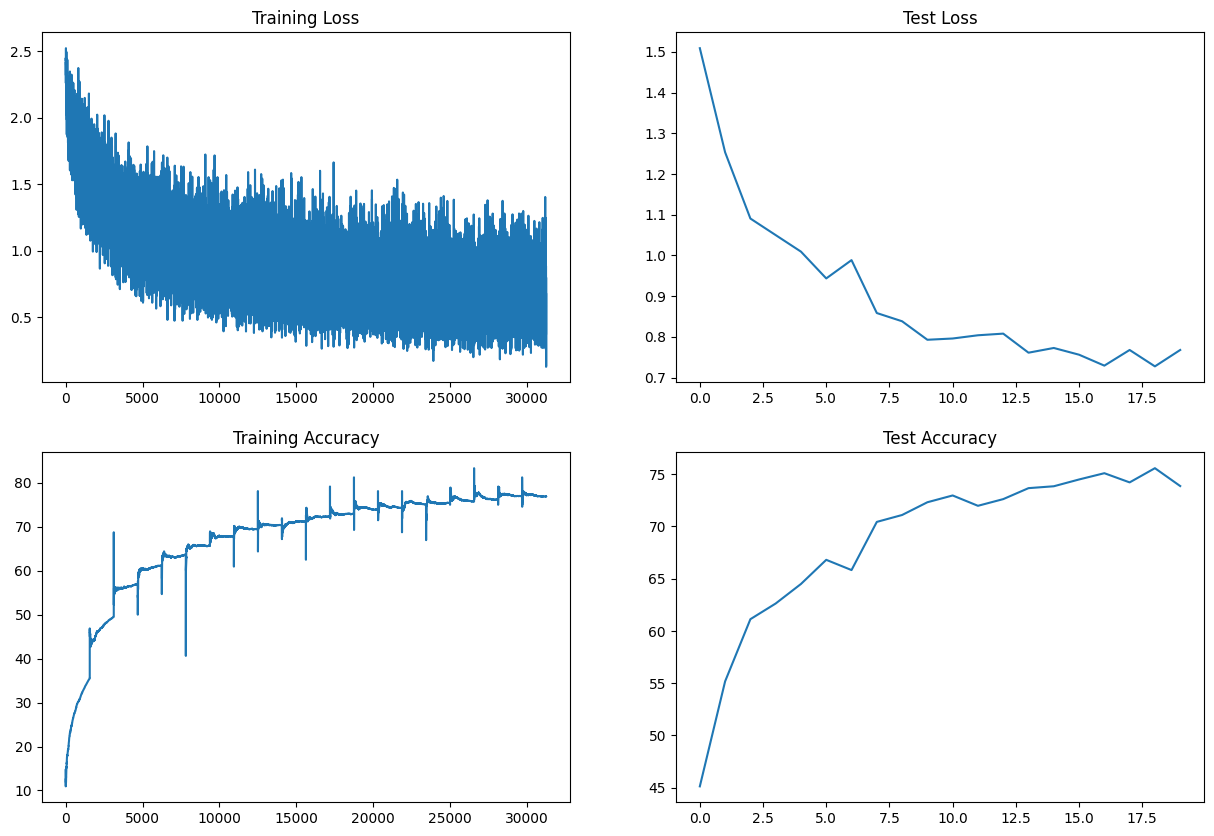

In [11]:
import matplotlib.pyplot as plt

t = [t_items.item() for t_items in train_losses]
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [13]:
class_map = {
    'plane': 0,
    'car': 1,
    'bird': 2,
    'cat': 3,
    'deer': 4,
    'dog': 5,
    'frog': 6,
    'horse': 7,
    'ship': 8,
    'truck': 9
}

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

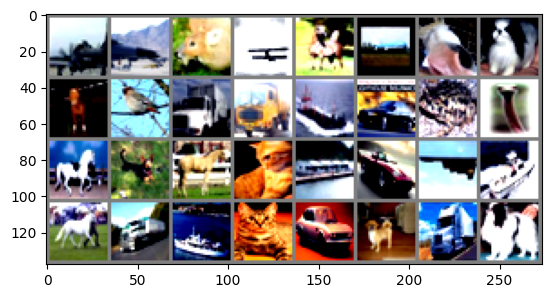

plane plane deer  plane horse plane horse dog   horse bird  truck truck ship  car   frog  bird  horse dog   horse cat   ship  car   plane ship  horse truck ship  cat   car   dog   truck dog  


In [30]:
from torchvision.utils import make_grid
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)


imshow(make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(32)))
